# Input data and distance measures

#### This notebook was developed by [Dalya Baron](https://obs.carnegiescience.edu/dalya-baron)  for the Vatican Observatory Summer School 2023.
<br>
In this notebook we will examine different aspects related to our treatment of the input data and the usage of different distance measures to define similarities between objects.<br>

<a id='toc'></a>

## This notebook includes:

[Feature scaling and normalization](#EX1)

[Correlated features](#EX2)

[Raw data and the Euclidean distance](#EX3)

In [59]:
from __future__ import print_function, division, absolute_import
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(42)
%matplotlib inline  

## Input data: aspects to consider when using derived features
### 1. Feature scaling and normalization<a id='EX1'></a>
[Go to top](#toc)<br><br>

As a very simple example, we will simulate a dataset with two features: galaxy stellar mass and galaxy metallicity. We will simulate galaxies with stellar masses ranging from $10^6\,M_{\odot}$ to $10^{10}\,M_{\odot}$, and will assume a log-uniform distribution of the stellar mass. For the metallicity, we will assume a bimodal distribution in metallicity, with metallicity around $0.5\,Z_{\odot}$ for lower mass galaxies, and a metallicity around $1\,Z_{\odot}$ for the higher mass galaxies.<br><br>
**Note** that the simulated objects do not follow the mass-metallicity relation, and do not represent real galaxies. This example is used only to illustrate the importance of feature scaling and normalization!

In [18]:
from scipy.stats import loguniform
from scipy.spatial import distance_matrix

Nobj = 1000
indices = np.arange(Nobj)

# generate stellar masses with a log-normal distirbution between 10^6 and 10^10
M_vec = loguniform.rvs(10**6, 10**10, size=Nobj)

# generate metallicities with a bimodal distribution around 0.1 and 1
Z_lowmass = 0.5
Z_highmass = 1
Z_scatter = 0.05

Z_vec = np.ones(len(M_vec))
indices_lowmass = indices[M_vec < 10**8]
indices_highmass = indices[M_vec >= 10**8]

Z_vec[indices_lowmass] = np.random.normal(loc=Z_lowmass, scale=Z_scatter, size=len(indices_lowmass))
Z_vec[indices_highmass] = np.random.normal(loc=Z_highmass, scale=Z_scatter, size=len(indices_highmass))

# our feature matrix will include two features: the stellar mass and redshift
data = np.column_stack([M_vec, Z_vec])
data.shape

(1000, 2)

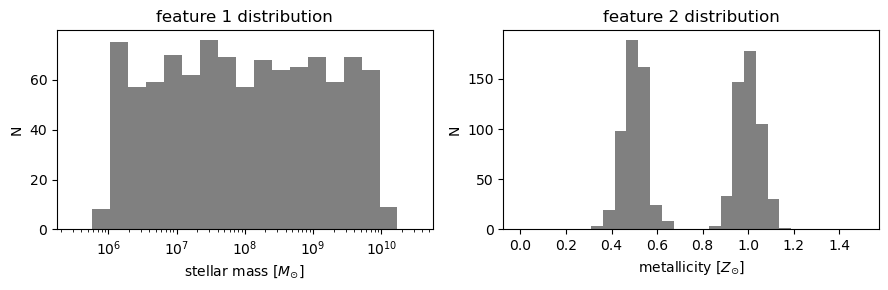

In [25]:
# plot the distributions of the two features
fig = plt.figure(1, figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.title("feature 1 distribution")
tmp = plt.hist(data[:, 0], bins=np.logspace(5.5, 10.5, 20), color="grey")
plt.xscale("log")
plt.xlabel("stellar mass [$M_{\\odot}$]")
plt.ylabel("N")

plt.subplot(1, 2, 2)
plt.title("feature 2 distribution")
tmp = plt.hist(data[:, 1], bins=np.linspace(0, 1.5, 30), color="grey")
plt.xlabel("metallicity [$Z_{\\odot}$]")
plt.ylabel("N")

plt.tight_layout()

To illustrate the impact of the two features on the summed Euclidean distance, we will calculate the pairwise distances between the objects when considering only the stellar mass, only the metallicity, and when considering both of the features.

In [26]:
# only stellar mass
D_f1 = distance_matrix(data[:, 0, None], data[:, 0, None])

# only metallicity
D_f2 = distance_matrix(data[:, 1, None], data[:, 1, None])

# considering both features
D_total = distance_matrix(data, data)

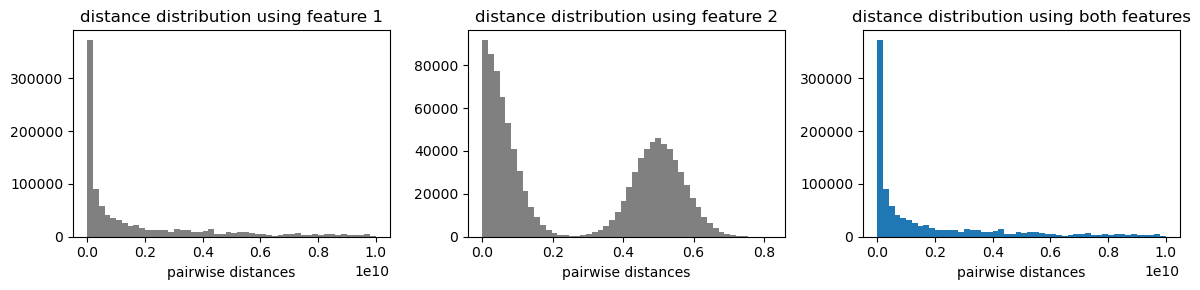

In [28]:
# plot the distribution of features in all cases
plt.figure(1, figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("distance distribution using feature 1")
tmp = plt.hist(D_f1.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 2)
plt.title("distance distribution using feature 2")
tmp = plt.hist(D_f2.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 3)
plt.title("distance distribution using both features")
tmp = plt.hist(D_total.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.tight_layout()

Compare the distances obtained when using only the first feature (stellar mass) and only the second (metallicity). We can see that the distances obtained when using the first feature are significantly larger than those obtained when using the second feature. <br>
The resulting distance matrix, when using both of the features, resembles the distance matrix obtained when using only the stellar mass. This means that the stellar mass feature dominates the distance measure, and will therefore dominate in any type of output obtained with unsupervised learning algorithms.

#### Scaling and normalization of the features
To allow for a more uniform weighting of the different features, we will do the following:
1. For each feature that is distributed over several magnitudes, we will take the logarithm of the value.
2. We will rescale each feature by the mean and standard deviation of the distribution. 

Let's start by taking to logarithm of the mass, and examine the distributions and distances. 

In [35]:
logM_vec = np.log10(M_vec)
data = np.column_stack([logM_vec, Z_vec])

# distance matrices
D_f1 = distance_matrix(data[:, 0, None], data[:, 0, None])
D_f2 = distance_matrix(data[:, 1, None], data[:, 1, None])
D_total = distance_matrix(data, data)

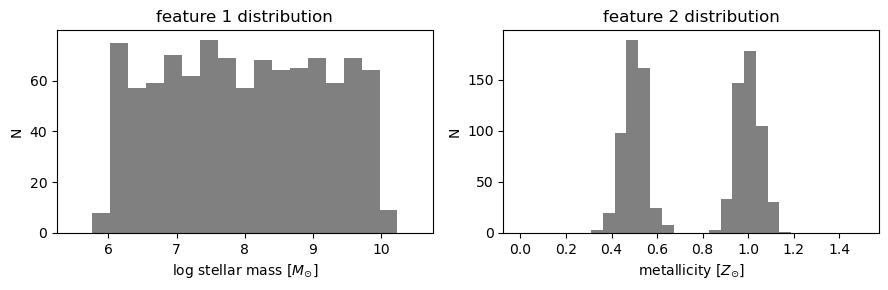

In [36]:
# plot the distributions of the two features
fig = plt.figure(1, figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.title("feature 1 distribution")
tmp = plt.hist(data[:, 0], bins=np.linspace(5.5, 10.5, 20), color="grey")
plt.xlabel("log stellar mass [$M_{\\odot}$]")
plt.ylabel("N")

plt.subplot(1, 2, 2)
plt.title("feature 2 distribution")
tmp = plt.hist(data[:, 1], bins=np.linspace(0, 1.5, 30), color="grey")
plt.xlabel("metallicity [$Z_{\\odot}$]")
plt.ylabel("N")

plt.tight_layout()

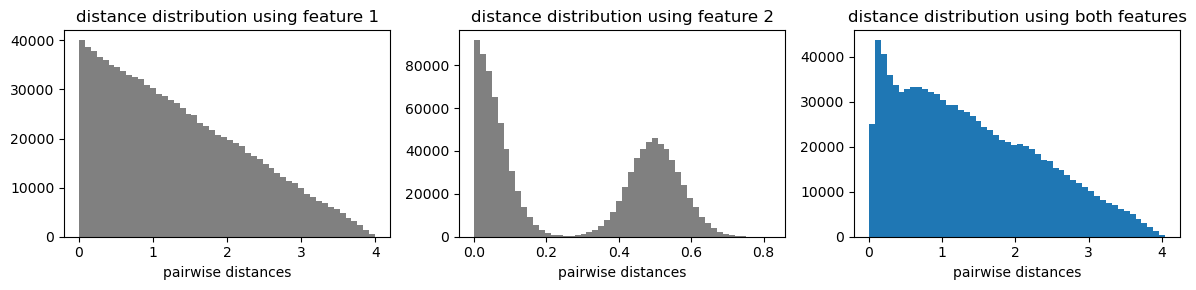

In [37]:
# plot the distribution of features in all cases
plt.figure(1, figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("distance distribution using feature 1")
tmp = plt.hist(D_f1.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 2)
plt.title("distance distribution using feature 2")
tmp = plt.hist(D_f2.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 3)
plt.title("distance distribution using both features")
tmp = plt.hist(D_total.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.tight_layout()

We start to see some evidence for a bimodal distribution in the pairwise distances of the distance matrix when considering both features. However, the stellar mass still dominates as it has a larger variance. Let's do step 2 and rescale both of the features!

In [38]:
Z_vec_rescaled = (Z_vec - np.mean(Z_vec)) / np.std(Z_vec)
logM_vec_rescaled = (logM_vec - np.mean(logM_vec)) / np.std(logM_vec)

data = np.column_stack([logM_vec_rescaled, Z_vec_rescaled])

# distance matrices
D_f1 = distance_matrix(data[:, 0, None], data[:, 0, None])
D_f2 = distance_matrix(data[:, 1, None], data[:, 1, None])
D_total = distance_matrix(data, data)

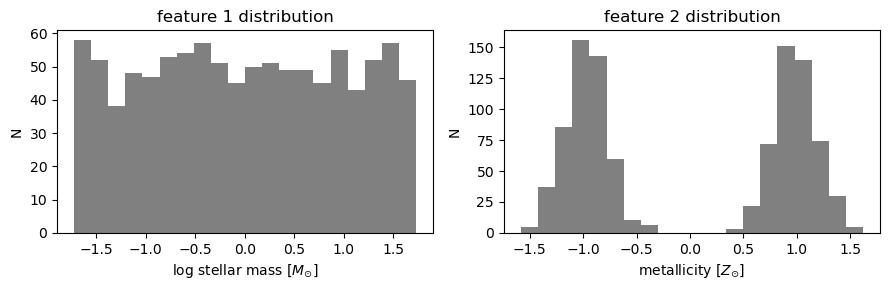

In [39]:
# plot the distributions of the two features
fig = plt.figure(1, figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.title("feature 1 distribution")
tmp = plt.hist(data[:, 0], bins=20, color="grey")
plt.xlabel("log stellar mass [$M_{\\odot}$]")
plt.ylabel("N")

plt.subplot(1, 2, 2)
plt.title("feature 2 distribution")
tmp = plt.hist(data[:, 1], bins=20, color="grey")
plt.xlabel("metallicity [$Z_{\\odot}$]")
plt.ylabel("N")

plt.tight_layout()

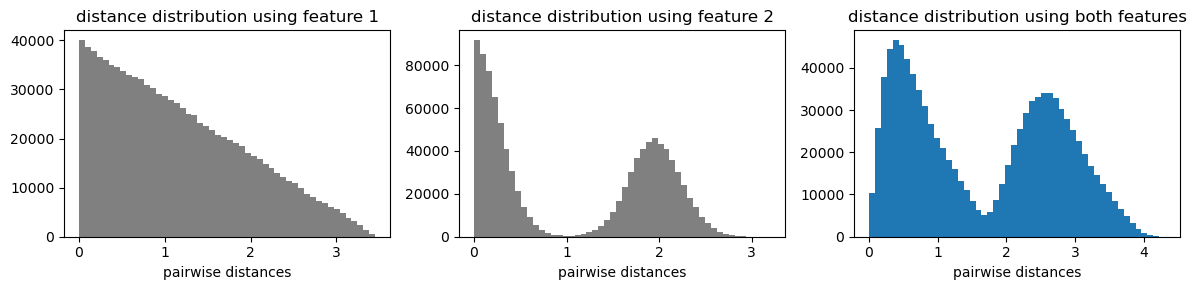

In [40]:
# plot the distribution of features in all cases
plt.figure(1, figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("distance distribution using feature 1")
tmp = plt.hist(D_f1.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 2)
plt.title("distance distribution using feature 2")
tmp = plt.hist(D_f2.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 3)
plt.title("distance distribution using both features")
tmp = plt.hist(D_total.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.tight_layout()

### 2. Correlated features<a id='EX2'></a>
[Go to top](#toc)<br><br>

To illustrate the impact of correlated features on our data, we will start by simulating a simple dataset with two features. One of the features will have a normal distribution, and the other will be bimodal. We will then add more and more correlated features to the data, and will examine the impact of adding them on the distance matrix.

Text(0, 0.5, 'feature 1')

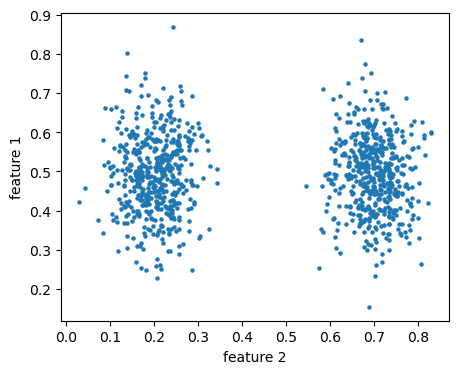

In [49]:
Nobj = 1000
indices = np.arange(Nobj)

# feature 1: normal distribution
f1_vec = np.random.normal(loc=0.5, scale=0.1, size=Nobj)

# feature 2: bimodal distribution
f2_vec = np.ones(Nobj)
f2_vec[:int(Nobj/2)] = np.random.normal(loc=0.2, scale=0.05, size=int(Nobj/2))
f2_vec[int(Nobj/2):] = np.random.normal(loc=0.7, scale=0.05, size=int(Nobj/2))

plt.figure(1, figsize=(5, 4))
plt.scatter(f2_vec, f1_vec, s=5)
plt.xlabel("feature 2")
plt.ylabel("feature 1")

In [50]:
# rescale and calculate distance matrices
f1_rescaled = (f1_vec - np.mean(f1_vec)) / np.std(f1_vec)
f2_rescaled = (f2_vec - np.mean(f2_vec)) / np.std(f2_vec)

data = np.column_stack([f1_rescaled, f2_rescaled])

# distance matrices
D_f1 = distance_matrix(data[:, 0, None], data[:, 0, None])
D_f2 = distance_matrix(data[:, 1, None], data[:, 1, None])
D_total = distance_matrix(data, data)

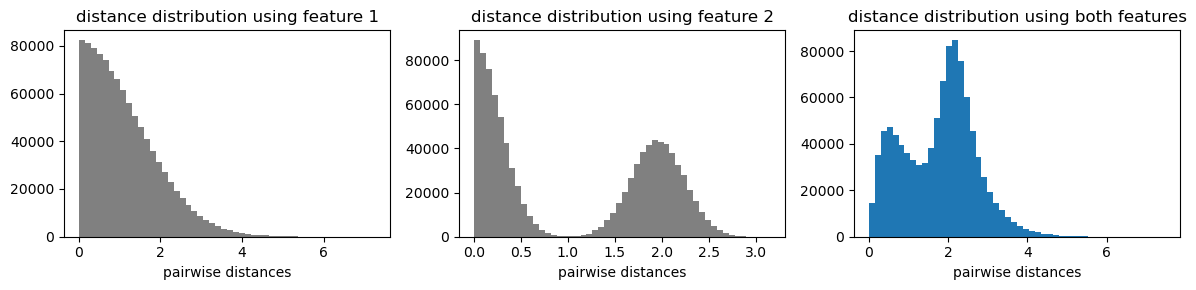

In [51]:
# plot the distribution of features in all cases
plt.figure(1, figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("distance distribution using feature 1")
tmp = plt.hist(D_f1.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 2)
plt.title("distance distribution using feature 2")
tmp = plt.hist(D_f2.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 3, 3)
plt.title("distance distribution using both features")
tmp = plt.hist(D_total.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.tight_layout()

We will now start adding features that are correlated with feature 1. We will start by adding only one such feature, and then will gradualy increase the number of such features. Let's examine what happens to the pairwise distance in each iteration.

In [53]:
f3_vec = 2 + 3 * f1_vec + np.random.normal(loc=0, scale=0.02, size=len(f1_vec))
f3_rescaled = (f3_vec - np.mean(f3_vec)) / np.std(f3_vec)

data = np.column_stack([f1_rescaled, f2_rescaled, f3_rescaled])

# distance matrices
D_f1 = distance_matrix(data[:, 0, None], data[:, 0, None])
D_f2 = distance_matrix(data[:, 1, None], data[:, 1, None])
D_f3 = distance_matrix(data[:, 2, None], data[:, 2, None])
D_total = distance_matrix(data, data)

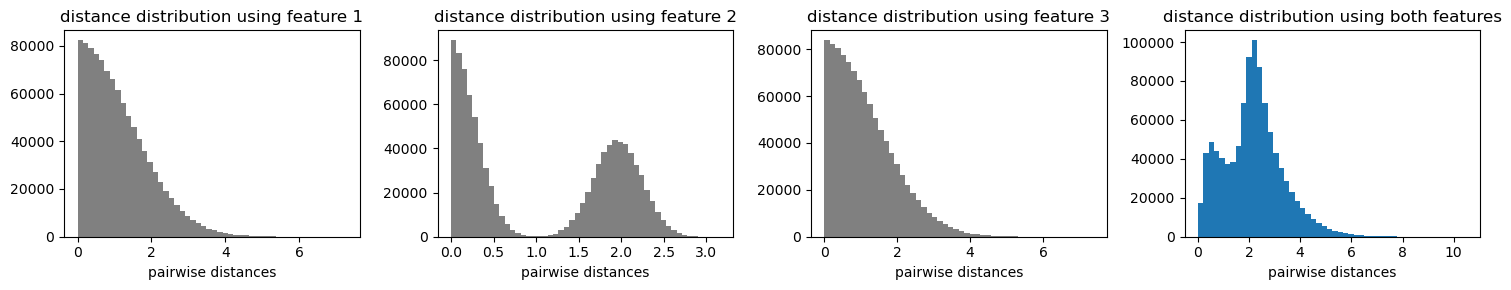

In [54]:
# plot the distribution of features in all cases
plt.figure(1, figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.title("distance distribution using feature 1")
tmp = plt.hist(D_f1.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 4, 2)
plt.title("distance distribution using feature 2")
tmp = plt.hist(D_f2.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 4, 3)
plt.title("distance distribution using feature 3")
tmp = plt.hist(D_f3.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 4, 4)
plt.title("distance distribution using both features")
tmp = plt.hist(D_total.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.tight_layout()

Now lets add 5 correlated features!

In [57]:
f4_vec = -1 + 2 * f1_vec + np.random.normal(loc=0, scale=0.02, size=len(f1_vec))
f5_vec = -0.5 - 2 * f1_vec + np.random.normal(loc=0, scale=0.02, size=len(f1_vec))
f6_vec = -0.5 - 0.1 * f1_vec + np.random.normal(loc=0, scale=0.02, size=len(f1_vec))
f7_vec = 2 - 0.5 * f1_vec + np.random.normal(loc=0, scale=0.02, size=len(f1_vec))

f4_rescaled = (f4_vec - np.mean(f4_vec)) / np.std(f4_vec)
f5_rescaled = (f5_vec - np.mean(f5_vec)) / np.std(f5_vec)
f6_rescaled = (f6_vec - np.mean(f6_vec)) / np.std(f6_vec)
f7_rescaled = (f7_vec - np.mean(f7_vec)) / np.std(f7_vec)

data = np.column_stack([f1_rescaled, f2_rescaled, f3_rescaled, f4_rescaled, f5_rescaled, f6_rescaled, f7_rescaled])

# distance matrices using only one of first two features
D_f1 = distance_matrix(data[:, 0, None], data[:, 0, None])
D_f2 = distance_matrix(data[:, 1, None], data[:, 1, None])

# distance matrix using the first two features
D_f12 = distance_matrix(data[:, :2], data[:, :2])

# distance matrix using all 7 features
D_total = distance_matrix(data, data)

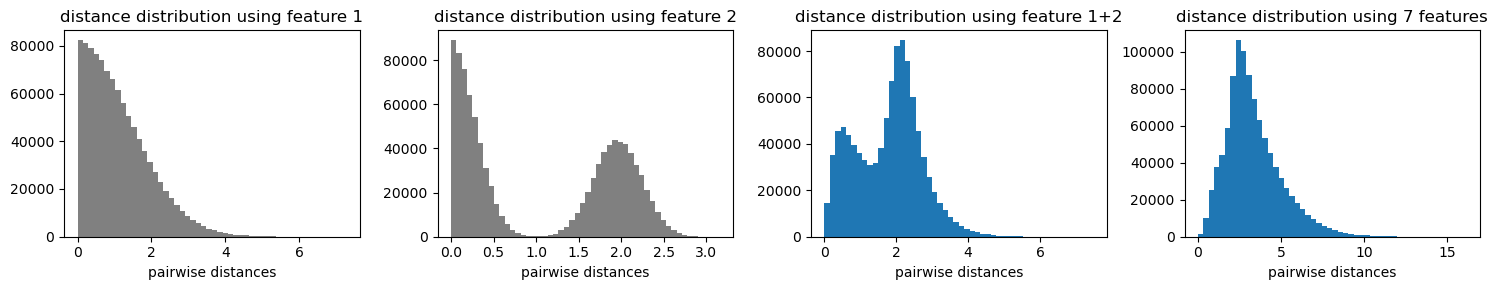

In [58]:
# plot the distribution of features in all cases
plt.figure(1, figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.title("distance distribution using feature 1")
tmp = plt.hist(D_f1.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 4, 2)
plt.title("distance distribution using feature 2")
tmp = plt.hist(D_f2.flatten(), bins=50, color="grey")
plt.xlabel("pairwise distances")

plt.subplot(1, 4, 3)
plt.title("distance distribution using feature 1+2")
tmp = plt.hist(D_f12.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.subplot(1, 4, 4)
plt.title("distance distribution using 7 features")
tmp = plt.hist(D_total.flatten(), bins=50)
plt.xlabel("pairwise distances")

plt.tight_layout()

We will return to this example when we learn about PCA!

### 3. Raw data and the Euclidean distance<a id='EX3'></a>
[Go to top](#toc) <br><br>

We will start by simulating an example that illustrates that:
1. Not all features are equally-important, and the Euclidean distance gives an equal weight to every feature.
2. It may be beneficial to transform the data into a different space.

To illustrate these points, we will load a single stellar population spectrum taken from the MILES library. We will create a version of the same spectrum that has some weak, almost unnoticable, noise in it. We will create another version of the spectrum by adding one emission line. We will then compare between the Euclidean distances between the three different spectra.

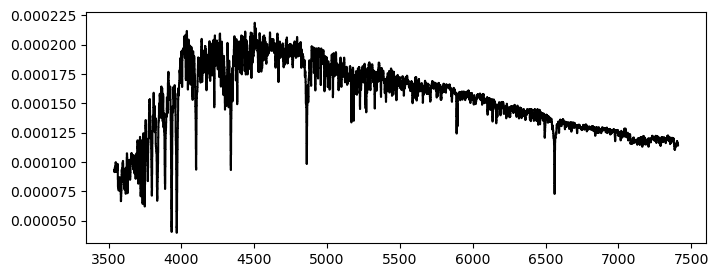

In [68]:
from astropy.io import fits

# load the spectrum
h = fits.open("data/MILES_models/Mch1.30Zp0.06T01.0000_iTp0.00_baseFe_linear_FWHM_2.51.fits")
header = h[0].header
wavelength = header['CRVAL1'] + header['CDELT1'] * np.arange(0, header['NAXIS1'])
flux = h[0].data

# plot the spectrum
plt.figure(1, figsize=(8, 3))
plt.step(wavelength, flux, "k")

In [112]:
## create thee different version of the spectrum
# version 1: no changes
f1 = np.copy(flux)

# version 2: add very weak Gaussian noise
f2 = flux + np.random.normal(loc=0, scale=np.median(flux)*0.02, size=len(flux))

# versin 3: add an emission line
emis_line = np.median(flux) * 0.5 * np.exp(-(wavelength - 5500)**2/1**2)
f3 = flux + emis_line

Text(0, 0.5, 'flux')

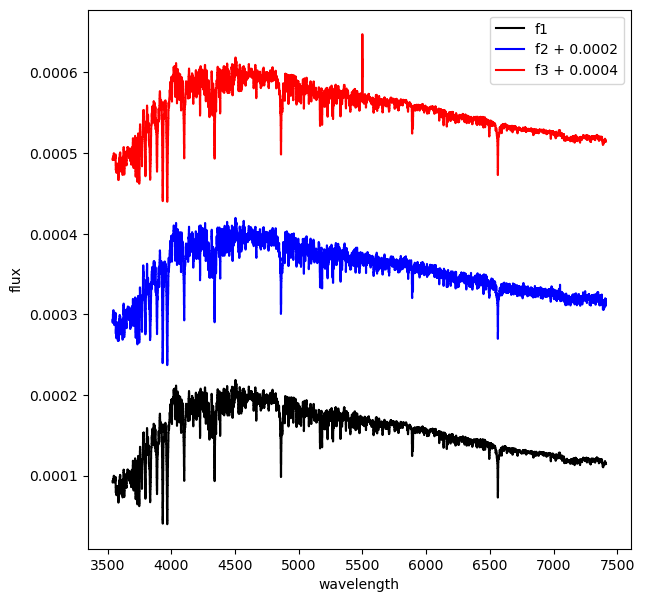

In [113]:
# plot all three spectra one above the other

plt.figure(1, figsize=(7, 7))

plt.step(wavelength, f1, "k", label="f1")
plt.step(wavelength, f2 + 0.0002, "b", label="f2 + 0.0002")
plt.step(wavelength, f3 + 0.0004, "r", label="f3 + 0.0004")

plt.legend(loc="upper right")

plt.xlabel("wavelength")
plt.ylabel("flux")

According to our visual perception, we would expect the distance between f1 and f2 to be small, and the distance between f3 and f1,f2 to be large, as it shows an additional emission line. Let's calculate the Euclidean distance and see what we get. 

In [114]:
D_12 = np.sum((f1 - f2)**2)**0.5
D_13 = np.sum((f1 - f3)**2)**0.5
D_23 = np.sum((f2 - f3)**2)**0.5

print("The Euclidean distance between f1 and f2: %.2f" % (D_12*1000))
print("The Euclidean distance between f1 and f3: %.2f" % (D_13*1000))
print("The Euclidean distance between f2 and f3: %.2f" % (D_23*1000))

The Euclidean distance between f1 and f2: 0.20
The Euclidean distance between f1 and f3: 0.09
The Euclidean distance between f2 and f3: 0.22


Interstingly, and perhaps contrary to our expectations, the distance between f1 and f3 is the lowest, suggesting that they are closer than to f2. This is surprising because f3 has this very clear emission line. The reason why the distance to f2 is larger is the noise we added to every pixel in the continuum. Although it makes almost no difference when we visually-inspect the spectrum, the spectrum is actually dominated by continuum pixels, so this adds up to be quite a lot!

We will now illustrate how the Euclidean distance does not depend on the relative order of the features, which can be very counterintuitive. We will shuffle the values in f1 and f3, present the shuffled versions, and measure the Euclidean distance. We will see that it will remain the same. That is, the **relative order of the features does not matter!**

The Euclidean distance between f1 and f3: 0.09
The Euclidean distance between f1 and f3 after shuffling: 0.09


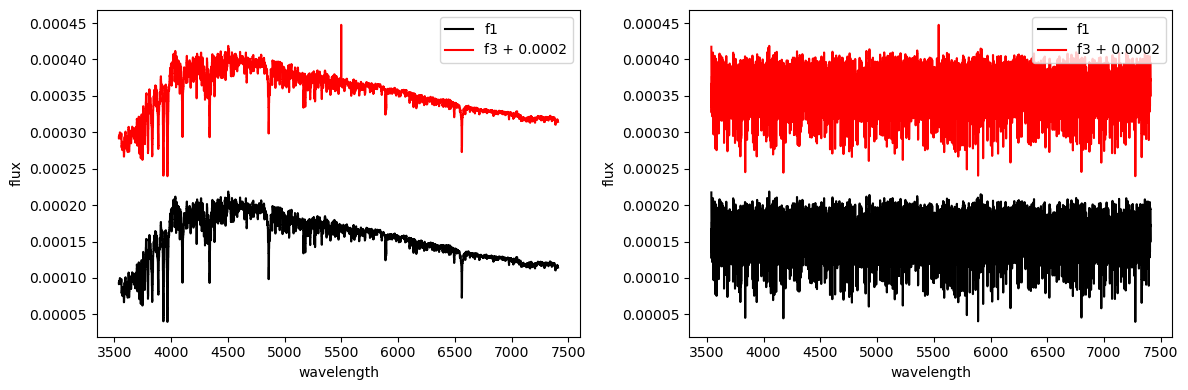

In [120]:
indices_shuf = np.arange(len(f1))
np.random.shuffle(indices_shuf)

f1_shuf = f1[indices_shuf]
f3_shuf = f3[indices_shuf]

D_13_shuf = np.sum((f1_shuf - f3_shuf)**2)**0.5

print("The Euclidean distance between f1 and f3: %.2f" % (D_13*1000))
print("The Euclidean distance between f1 and f3 after shuffling: %.2f" % (D_13_shuf*1000))

plt.figure(1, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.step(wavelength, f1, "k", label="f1")
plt.step(wavelength, f3 + 0.0002, "r", label="f3 + 0.0002")

plt.legend(loc="upper right")
plt.xlabel("wavelength")
plt.ylabel("flux")

plt.subplot(1, 2, 2)
plt.step(wavelength, f1_shuf, "k", label="f1")
plt.step(wavelength, f3_shuf + 0.0002, "r", label="f3 + 0.0002")

plt.legend(loc="upper right")
plt.xlabel("wavelength")
plt.ylabel("flux")


plt.tight_layout()

## Homework, if you'd like
Use other distance measures to estimate the distance between f1 and f3, once for the original spectra and once for the shuffled versions. Consider the following distance metrics: 
1. Earth Mover's distance, also named Wasserstein Distance (see scipy.stats.wasserstein_distance).
2. Energy distance (see scipy.stats.energy_distance).
3. KL divergence (see scipy.special.kl_div).
4. Any other distance you'd like from, e.g., sklearn.metrics.DistanceMetric.